In [1]:
println(VERSION, " (", Sys.CPU_NAME, ")")

1.7.0 (cyclone)


In [2]:
println("[*] Checking runtime dependencies")
import Pkg
Pkg.activate(".")
Pkg.add("Unitful")
Pkg.add("DataStructures")
Pkg.add("Distributions")
Pkg.add("IterativeSolvers")
Pkg.add("Interpolations")
Pkg.add("ProgressMeter")
Pkg.add("SparseArrays")
Pkg.add("StaticArrays")
Pkg.resolve()

[*] Checking runtime dependencies


  Activating project at `~/iskra`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
  No Chang

In [3]:
struct Config
  diagnostics
  solver
  pusher
  interactions
  species
  grid
end

In [4]:
# + units and constants
using Unitful
↦(value::Unitful.Units, unit::Unitful.Units) = Unitful.convfact(unit, value)
↦(value::Unitful.Quantity, unit::Unitful.Units) = uconvert(unit, value).val

# units
const °C = u"°C"
const K  = u"K"  ↦ u"K"
const kB = u"k"  ↦ u"J/K"
const C  = u"C"  ↦ u"C"
const V  = u"V"  ↦ u"V"
const m  = u"m"  ↦ u"m"
const cm = u"cm" ↦ u"m"
const u  = u"u"  ↦ u"kg"
const s  = u"s"  ↦ u"s"
const ms = u"ms" ↦ u"s"
const ns = u"ns" ↦ u"s"
const ps = u"ps" ↦ u"s"
const μs = u"μs" ↦ u"s"
const kA = u"kA" ↦ u"A"
const kV = u"MV" ↦ u"V"
const MV = u"MV" ↦ u"V"
const eV = u"eV" ↦ u"eV"
const kg = u"kg" ↦ u"kg"
const mps = u"m/s" ↦ u"m/s"
const kmps = u"km/s" ↦ u"m/s"
const kHz = u"kHz" ↦ u"Hz"
const MHz = u"MHz" ↦ u"Hz"

# constants
const ɛ0 = u"ɛ0" ↦ u"F/m"
const c0 = sqrt(u"1/ɛ0" * u"1/μ0") ↦ u"m/s"
const qe = 1.602_176_6208e-19C  # elementary charge
const me = 9.109_383_7015e-31kg # mass of electron
const mp = 1.672_621_8982e-27kg # mass of proton
nothing

In [5]:
function thermal_speed(T, m)
  sqrt(2kB*T/m)
end

thermal_speed (generic function with 1 method)

In [6]:
# + spatial and temporal paramters
const ts = 5000
const nx = 73

const νtherm = thermal_speed(300K, me)
const νdrift = 2.48e8 # m/s

const Lx = 0.372m
const Δh = Lx / nx
const Δt = 5ps
const electronNumRatio = 3e10
const simulationVolume = nx * Δh
const numCells         = nx


println("Δt: ", Δt, "\nΔh: ", Δh, "\nLx: ", Lx)
println("νtherm: ", round(νtherm/c0; sigdigits=1), "c")
println("νdrift: ", round(νdrift/c0; sigdigits=3), "c")
println("real particles per macroparticle: ", electronNumRatio)

Δt: 1//200000000000
Δh: 0.005095890410958904
Lx: 0.372
νtherm: 0.0003c
νdrift: 0.827c
real particles per macroparticle: 3.0e10


In [7]:
using StaticArrays
include("ParticleInCell/src/pic/kinetic.jl");

In [8]:
# + species and sources
const e   = KineticSpecies{1,3}(:e,  200_000, -1qe, 1me,  electronNumRatio)

include("ParticleInCell/src/pic/sources.jl")
const beam = MaxwellianSource{1,3}(12kA / 1qe / electronNumRatio, [2Δh], [0.,0.,0.], dv=[+νdrift,0.,0.])

const species = [e]

1-element Vector{KineticSpecies{1, 3}}:
 e

In [9]:
using LinearAlgebra
using Statistics
using SparseArrays
include("pole/boundary_conditions.jl")
include("pole/gradient.jl")
include("pole/iterative_methods.jl")
include("pole/inplace_periodic_solver.jl")
include("pole/linear_solver.jl")
include("pole/linear_solver1.jl")

solution(ps::LinearSolver) = reshape(ps.u, ps.n...)
gradient(ps::LinearSolver) = GradientOperator(ps.n[1], ps.δ[1], ps.bcs)

function create_poisson_solver(grid, ε0)
    xf, = grid.coords
    ps = LinearSolver(xf)
end

function calculate_electric_potential(ps, f)
    @inbounds for i in eachindex(f)
      f[i] /= ε0
    end
    solve!(ps, f)
    φ  = solution(ps)
    φ.-= mean(φ)
end

calculate_electric_potential (generic function with 1 method)

In [10]:
using LinearAlgebra, StaticArrays
const xs = 0m:Δh:Lx
include("RegularGrids/src/uniform_grid.jl")
include("ParticleInCell/src/pic/pushers.jl")
const grid    = create_uniform_grid(xs)
const solver  = create_poisson_solver(grid, ε0)
const pusher  = create_boris_pusher(species)
nothing

In [27]:
include("ParticleInCell/src/pic/wrap.jl")

function after_push(part, grid)
  discard!(part, grid, 1)
end

function enter_loop()
    e.np = 0
end

enter_loop (generic function with 1 method)

In [70]:
using Random; Random.seed!(0)

function after_loop(i, t, dt)
    diagnostics["ne-"][i] = e.np
  sample!(beam, e, Δt)
end
function exit_loop() end

const diagnostics = Dict{String, Array{Float64, 2}}(
    "ne-"  => zeros(1, ts),
    "rho"  => zeros(nx, ts),
    "phi"  => zeros(nx, ts),
    "Jx"   => zeros(nx+1, ts),
    "Ex"   => zeros(nx+1, ts))

const config = Config(diagnostics, solver, pusher, [], species, grid)
println("[*] Running simulation")

struct FluidSpecies end
include("ParticleInCell/src/pic/algorithm.jl")
include("ParticleInCell/src/pic/cloud_in_cell.jl")
@time solve(config, Δt, ts)

[*] Running simulation
Complete!
  1.682168 seconds (1.23 M allocations: 512.926 MiB, 13.73% gc time, 8.52% compilation time)


In [71]:
import Pkg
Pkg.activate(".")
Pkg.add("PyPlot")
Pkg.resolve()

  Activating project at `~/iskra`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`


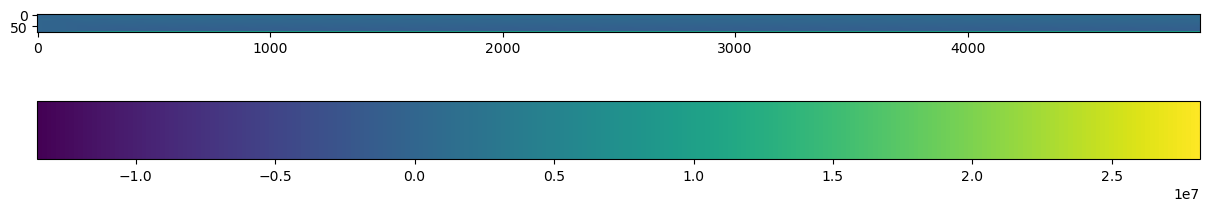

In [72]:
using PyPlot
figure(figsize=(15, 6))
imshow(diagnostics["Ex"])
colorbar(orientation="horizontal")
#display(gcf());

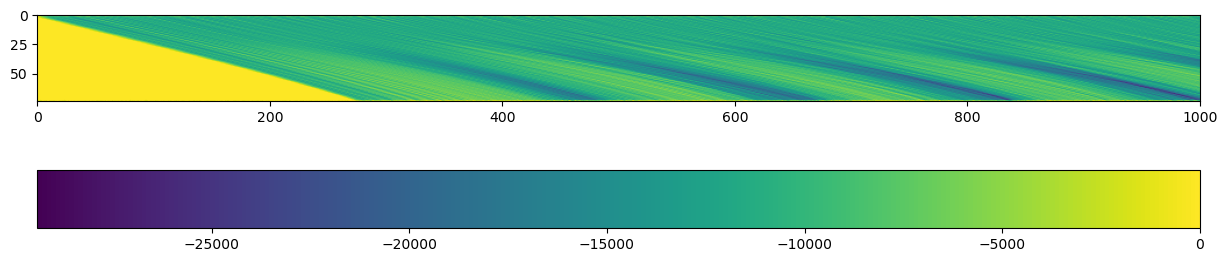

(0.0, 1000.0)

In [73]:
figure(figsize=(15, 6))
imshow(diagnostics["Jx"])
colorbar(orientation="horizontal")
xlim((0,1000))
#display(gcf())

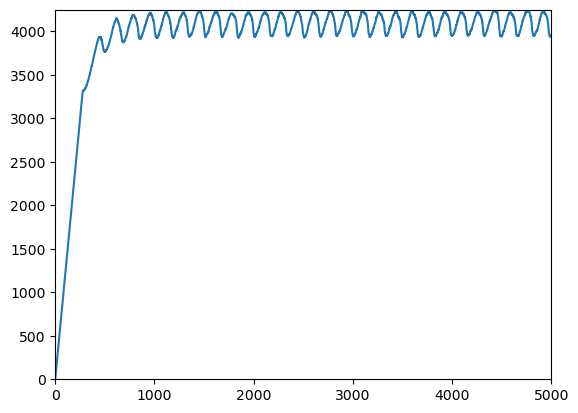

(0.0, 4250.0)

In [74]:
figure()
plot(diagnostics["ne-"][:])
xlim((0, 5000))
ylim((0, 4250))
#display(gcf())

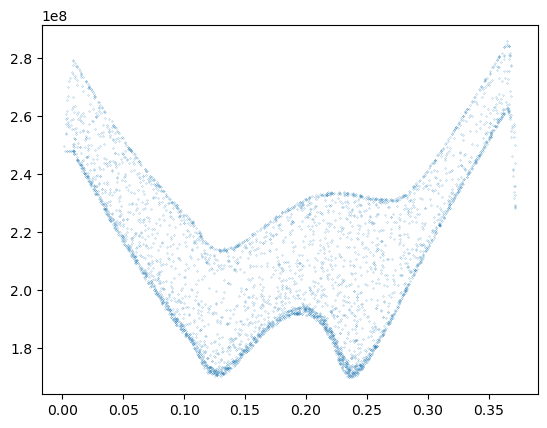

PyObject <matplotlib.collections.PathCollection object at 0x1425ac310>

In [75]:
figure()
scatter([e.x[p] for p in 1:e.np], [e.v[p][1] for p in 1:e.np], marker=".", s=0.1)
#display(gcf())

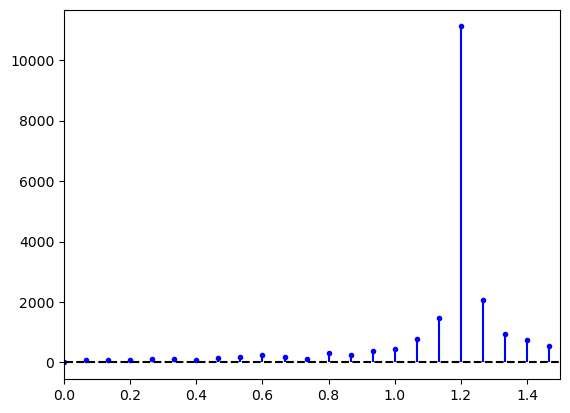

(0.0, 1.5)

In [158]:
using FFTW

figure()

let
    jx = sum(diagnostics["Jx"][51:55,2000:4000]; dims=1)[:]
    Jx = fft(jx .- mean(jx))
    samples = length(jx)
    fNy = 0.5 / Δt

    Jx ./= samples

    frequencies = 1e-9range(-fNy, +fNy, length=samples)

    #stem(frequencies, abs.(fftshift(Jx)), linefmt="k-", markerfmt="k.", basefmt="k--")
end
let
    jx = sum(diagnostics["Jx"][51:55,3000:5000]; dims=1)[:]
    Jx = fft(jx .- mean(jx))
    samples = length(jx)
    fNy = 0.5 / Δt

    Jx ./= samples

    frequencies = 1e-9range(-fNy, +fNy, length=samples)

    #stem(frequencies, abs.(fftshift(Jx)), linefmt="r-", markerfmt="r.", basefmt="k--")
end
let
    jx = sum(diagnostics["Jx"][51:55,2000:5000]; dims=1)[:]
    Jx = fft(jx .- mean(jx))
    samples = length(jx)
    fNy = 0.5 / Δt

    Jx ./= samples

    frequencies = 1e-9range(-fNy, +fNy, length=samples)

    stem(frequencies, abs.(fftshift(Jx)), linefmt="b-", markerfmt="b.", basefmt="k--")
end
xlim((0., 1.5))